<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#clarification" data-toc-modified-id="clarification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>clarification</a></span><ul class="toc-item"><li><span><a href="#python-dependencies" data-toc-modified-id="python-dependencies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>python dependencies</a></span></li><li><span><a href="#compiling-s3d" data-toc-modified-id="compiling-s3d-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>compiling <code>s3d</code></a></span></li><li><span><a href="#data-for-cross-val" data-toc-modified-id="data-for-cross-val-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>data for cross val</a></span></li><li><span><a href="#data-format" data-toc-modified-id="data-format-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>data format</a></span></li><li><span><a href="#file-structure" data-toc-modified-id="file-structure-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>file structure</a></span></li><li><span><a href="#example-datasets" data-toc-modified-id="example-datasets-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>example datasets</a></span></li></ul></li><li><span><a href="#create-s3d-model" data-toc-modified-id="create-s3d-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>create <code>s3d</code> model</a></span></li><li><span><a href="#train" data-toc-modified-id="train-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>train</a></span></li><li><span><a href="#visualize-the-trained-model" data-toc-modified-id="visualize-the-trained-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>visualize the trained model</a></span><ul class="toc-item"><li><span><a href="#steps" data-toc-modified-id="steps-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>steps</a></span></li><li><span><a href="#feature-network" data-toc-modified-id="feature-network-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>feature network</a></span></li><li><span><a href="#feature-binning-(1d)" data-toc-modified-id="feature-binning-(1d)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>feature binning (1d)</a></span></li><li><span><a href="#feature-binning-(2d~4d)" data-toc-modified-id="feature-binning-(2d~4d)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>feature binning (2d~4d)</a></span><ul class="toc-item"><li><span><a href="#frequency" data-toc-modified-id="frequency-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>frequency</a></span></li><li><span><a href="#expected-value" data-toc-modified-id="expected-value-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>expected value</a></span></li><li><span><a href="#predictions" data-toc-modified-id="predictions-4.4.3"><span class="toc-item-num">4.4.3&nbsp;&nbsp;</span>predictions</a></span></li></ul></li></ul></li><li><span><a href="#hyperparameter-tuning" data-toc-modified-id="hyperparameter-tuning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>hyperparameter tuning</a></span></li><li><span><a href="#multi-core-hyperparam-tuning" data-toc-modified-id="multi-core-hyperparam-tuning-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>multi core hyperparam tuning</a></span></li><li><span><a href="#predict-(for-one-fold)" data-toc-modified-id="predict-(for-one-fold)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>predict (for one fold)</a></span></li><li><span><a href="#score-(for-one-fold)" data-toc-modified-id="score-(for-one-fold)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>score (for one fold)</a></span></li><li><span><a href="#test-for-each-fold" data-toc-modified-id="test-for-each-fold-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>test for each fold</a></span><ul class="toc-item"><li><span><a href="#best-params-for-each-fold" data-toc-modified-id="best-params-for-each-fold-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>best params for each fold</a></span></li><li><span><a href="#evaluation-of-s3d" data-toc-modified-id="evaluation-of-s3d-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>evaluation of s3d</a></span></li></ul></li><li><span><a href="#use-case:-regression-on-bike-sharing-dataset" data-toc-modified-id="use-case:-regression-on-bike-sharing-dataset-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>use case: regression on bike sharing dataset</a></span><ul class="toc-item"><li><span><a href="#cross-validation" data-toc-modified-id="cross-validation-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>cross validation</a></span></li><li><span><a href="#visualization" data-toc-modified-id="visualization-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>visualization</a></span></li></ul></li></ul></div>

a quickstart on using python apis for `s3d` model

original c code: https://github.com/peterfennell/S3D

---

In [1]:
import utils, warnings
import pandas as pd
warnings.simplefilter('once')

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
from pys3d import PYS3D

In [3]:
import matplotlib.colors as mc
from matplotlib import pyplot as plt
%matplotlib inline

---

### clarification

the design of the constructor is meant to be easy for hyperparameter tuning by cross validation. therefore, the methods `fit` and `predict` may be a little weird to use as standalone functions.

feel free to directly jump to the [use case](#usecase) for a quick tour on how to use `pys3d` wrapper

#### python dependencies

- `pandas`
- `joblib`
- `networkx` (the latest version has the edge arrow fixed!)
- `matplotlib`
- `scikit-learn`
- `seaborn`
- `palettable`

these can be installed by:
```bash
> pip install -r requirements.txt
```

#### compiling `s3d`

compiling is simple and straight forward, do:
```bash
> make all
```
or 
```bash
> make clean && make all
```
to remove previous compiled files.

#### data for cross val

for cross validation processes, datasets should be splitted first. the script `split_data.py` can be used to do so:

```bash
> python split_data.py -h
usage: split_data.py [-h] [-cf {0,1}] [-j NUM_JOBS] data_name num_folds

positional arguments:
  data_name             data to be splitted
  num_folds             number of folds

optional arguments:
  -h, --help            show this help message and exit
  -cf {0,1}, --classification-flag {0,1}
                        whether the dataset is for classification or not
                        (default 1 - yes); 0 for regression
  -j NUM_JOBS, --num-jobs NUM_JOBS
                        the number of parallel jobs (default 1)
```

this will read in `data_name.csv` from `data/` folder; split data and store the train/test sets into `splitted_data/data_name/` folder. 

for example, if there is a dataset called `breastcancer.csv` in `data/`, we can do:
```bash
> python split_data.py breastcancer 5
```

if we do `ls splitted_data/breastcancer/`, we will see:
```bash
0  1  2  3  4
```
which are fold indices named folder, each of which there will be:
```bash
num_rows.csv  test.csv  train.csv
```

where `train.csv` is the training set; `test.csv` is the testing set; `num_rows.csv` store the number of rows in train/test respectively.

finally, you can parallelize the data partitioning with more cores:
```bash
> ptyhon split_data.py -j num_jobs data_name num_folds
```

where `num_jobs` is 1 by default.

finally, it is noteworthy that by default, [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) from `sklearn` will be used for splitting classification datasets.

for regression datasets, one needs to specify `-cf 0` or `--classification-flag 0`. for example the `bike` dataset is for regression and we will do:
```bash
> python split_data.py -cf 0 bike 5
```

#### data format

data format: in `data_name.csv`, the first column is the target column named `target`, followed by features:
> `target,feature_1,feature_2,...,feature_p`

#### file structure

file directory setup: `PYS3D` class will by default create subfodlers `data_name` in:
```bash
tmp/ predictions/ models/ cv/
```

where:
- `tmp` will store the "inner cross validation" temporary files
- `predictions` will store the prediction results
- `models` will store the trained models
- `cv` will store the cross validation performance (on the validation set)

therefore, the first step is to create all these 4 for your convenience. you can do:
```bash
> ./init
```
which will cleanup and create these folders

reversely, run `./cleanup` to remove these folders

#### example datasets

the two datasets both come from [uci machine learning repository](https://archive.ics.uci.edu/ml/index.php)
- `breacancer`: [link](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29)
- `bike`: hourly [link](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

---

### create `s3d` model

suppose the dataset is stored at `../splitted_data/`, all we need for the model is the name of the dataset of interest

In [5]:
help(PYS3D.__init__)

Help on function __init__ in module pys3d:

__init__(self, data_name, data_path='../splitted_data/', model_path='models/', prediction_path='predictions/', classification_flag=True)
    initializer
    
    parameters
    ----------
    data_name : str
        intput data name
    data_path : str
        input data base path
    model_path : str
        base path for output of built models
    prediction_path : str
        base path for predicted expectations
    classification_flag : bool
        whether this is classification or regression. tihis is used for determining evaluation metrics
    
    for each path, we assume that there are sub folders for each test fold



In [6]:
data_name = 'breastcancer'
fold_index = 1

In [7]:
%%bash
./cleanup
./init

tmp not exist, create
models not exist, create
predictions not exist, create
cv not exist, create


In [8]:
s3d = PYS3D(data_name)

...s3d initializing...
s3d with breastcancer data, splitted into 5 folds
data will be loaded from ../splitted_data/breastcancer/
built models will be saved to models/breastcancer/
predictions will be saved to predictions/breastcancer/
temporary subfolders in  ./tmp/breastcancer
...done initializing...



section 3 and 4 describes the typical training/testing process for one of the folds

section 5 starts to 

---

### train

there are two required input arg:
- `train_data_path`: the path to the dataset. assume that the target is in the first column 
- `train_model_path`: the path to save the model

In [9]:
train_data = '../splitted_data/{}/{}/train.csv'.format(data_name, fold_index)
train_model = 'test-folder/'

In [10]:
s3d.fit(train_data, train_model, lambda_=0.001, max_features=5)

the outputs will be saved to `test-folder/` in our case

---

### visualize the trained model

#### steps

we can visualize chosen features at each step and the unique contribution of $R^2$

note that, we highlight the bars whose corresponding features have the most contribution of $\Delta R^2$ by heavy bar borders.

further, from time to time, there may be more than one feature with the same $\Delta R^2$ (due to feature redundancy). s3d will only select one of them, while the bars of the other features will be highlighted using lighter borders (but still more obvious than other features).

for example, while `clump_thickness` is selected, `cell_size`, `normal_nucleoli`, and `marginal_adhesion` in fact share the same contribution of variation explanation, though not selected.

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2347: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):


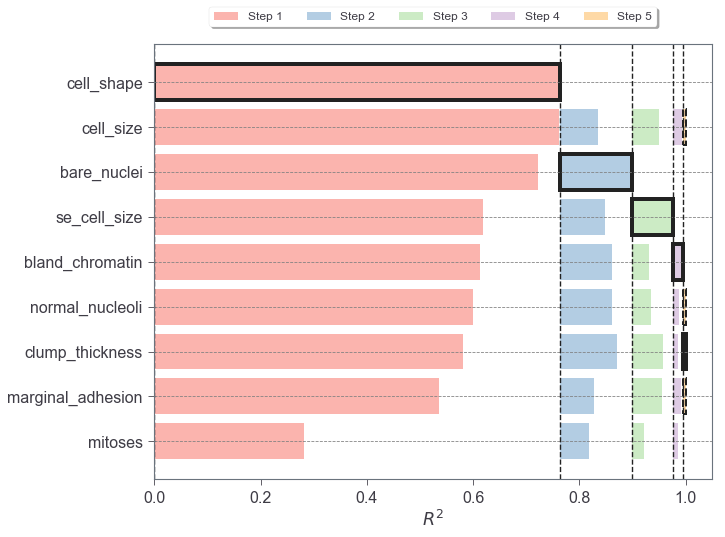

In [15]:
fig, ax = utils.visualize_s3d_steps(train_model, figsize=(10,8))

if there are too many features, there is an option to set `max_features=k` by limiting only the top `k` features in the bar chart. the minimum `k` should be the number of selected features (which is usually small) and not larger than the total number of features.

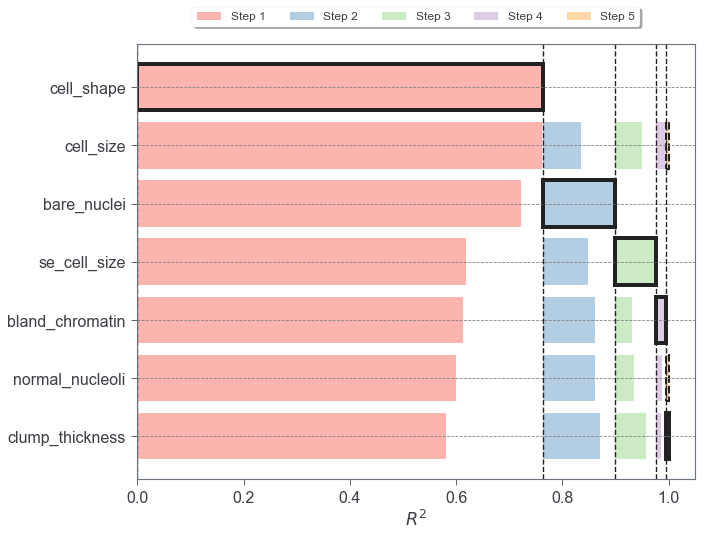

In [16]:
fig, ax = utils.visualize_s3d_steps(train_model, figsize=(10,8), max_features=7)

#### feature network

we can also visualize the redundancy between features:
- node: features
- edge
    - direction: from thee unselected feature ($X_j$) to the selected one ($X_l$)
    - width: "variation redundancies" of $X_j$ made by selecting $X_l$:
        $$a_{X_j,X_l^S}=\Delta R^2(P_{X_j}|\mathcal{P}^{S(l-1)}) - \Delta R^2(P_{X_j}|\mathcal{P}^{S(l-1)}\times P_{X_l^S})$$
- color: distinguish selected/unselected (and maybe isolated those w/o much contribution to the target)

In [ ]:
net, (fig, ax) = utils.visualize_feature_network(model_folder=train_model, w_scale=5)

#### feature binning (1d)

sometimes customization needed to improve the overall quality

in the case of one feature, we will be using a line chart to visualize the s3d model

In [11]:
pink_color = '#FBB4AE'
my_cmap = mc.LinearSegmentedColormap.from_list('custom_pink', ['#ffffff', pink_color], N=256)

In [12]:
dim = 1
thres = 0.33
splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, dim, thres)

y value of a horizontal line corresponds to the expeceted value of target variable in side that specific bin.

for example, for cell shape varying from 4 to 10, the expected value $E[Y] \approx 1$

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2347: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):


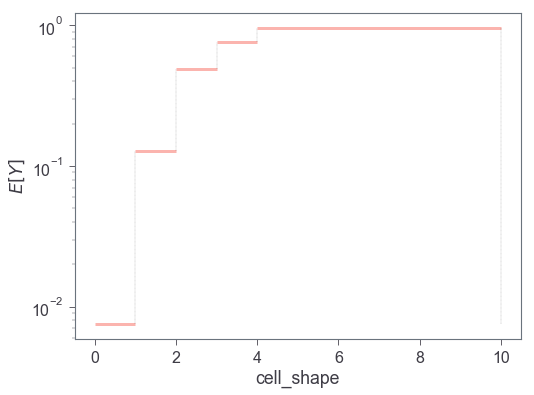

In [13]:
fig, ax = utils.visualize_s3d_model_1d(splits_at_dim, intensity_dim, 
                                       xlab=chosen_f_dim[0], ylab=r'$E[Y]$',
                                       xscale='linear',
                                       hlines_kwargs={'color': pink_color, 'linewidth': 3}
                                      )

#### feature binning (2d~4d)

when more than 1 feature is wanted, we need to use a heatmap-style plot. reading the heatmaps are similar to the line, except in higher dimensions.

first calll `utils.visualize_s3d_model_reader` to obtain _bins_. 3 required inputs:
- `model_folder`: `train_model` in our case
- `dim`: how many feature to use (2, 3, or 4)
- `thres`: classification threhold

In [16]:
dim = 3
thres = 0.33

In [17]:
splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, dim, thres)

we can plot the heatmap for 3 types of data:
- frequency: the frequency of data points - use `N_dim`
- y bar: $E[y]$, the expected targat values - use `intensity_dim`
- prediction: predicted class/label - use `pred_dim`

also note that, you can use `{x,y}bins_lab_decimal` to control the precision of bins in x/y label for dimension larger than 2

##### frequency

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2364: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


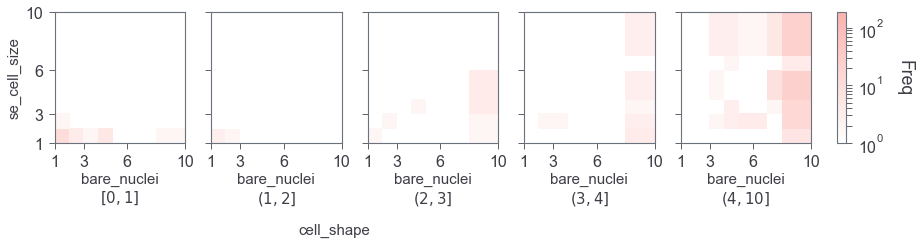

In [18]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap,
                                        N_dim, 'Freq', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                        norm_func=mc.LogNorm,
                                        xbins_lab_decimal=0,
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

##### expected value

In [ ]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap, 
                                        intensity_dim, '$E[y]$', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                        xbins_lab_decimal=1,
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

##### predictions

for this, a more customized discrete colormap is recommended

In [ ]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, 
                                        mc.ListedColormap(['white'] + [pink_color]*int(round(1/thres-1))), 
                                        pred_dim, 'Predictions', chosen_f_dim, 
                                        xscale='linear', yscale='linear', 
                                        cb_kwargs={'aspect':30, 'ticks': [0, thres, 1]},
                                        xbins_lab_decimal=3,
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

---

### hyperparameter tuning

it is convenient to tune the hyperparameters: 
- $\lambda$: regularization strength
- number of features: number of features to use (we like parsimonious models!)

the function to call is `pys3d.cross_val`:

In [ ]:
help(s3d.cross_val)

the required input are $\lambda$'s and numbers of features

from the above figure, we see the 5th feature really contributes very little, so let's set the maximum features to be 4

In [ ]:
lambda_list = [0.001, 0.003, 0.0001, 0.0003]
num_features = 4
data_name

In [ ]:
s3d = PYS3D(data_name)

In [ ]:
s3d.cross_val(lambda_list, num_features, calc_threshold=True)

the resulting file will be at `cv/data_name/performance.csv`

In [ ]:
cv_df = pd.read_csv('cv/{}/performance.csv'.format(data_name))
cv_df.head(2)

we can further visualize the train/validation performance, which also returns:
- the best number of features and $\lambda$
- as well as the value of the given metric (by default it uses [`auc micro`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score))

__note that we need to specify which split to be analyzed - different splits may have slightly different hyperparams__

In [ ]:
metric = 'auc_micro'
metric_name = 'Area Under the Curve'
legend_kwargs = {'ncol': 1, 'loc': 7, 'labelspacing': 1,
                 'title': r'$\lambda$ values',
                 'prop': {'size': 12},
                 'bbox_to_anchor': (1, .5),
                }

In [ ]:
fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         validation_metric=metric,
                                                                         metric_name=metric_name,
                                                                         legend_kwargs=legend_kwargs,
                                                                         split_version=0,)

In [ ]:
print('for split version {}...\nbest number of features: {}\nbest lambda: {}'.format(split_version, best_n_f, best_lambda_))

change the metric to accuracy; check out a different fold

In [ ]:
metric = 'accuracy'
metric_name = 'Accuracy Score'

In [ ]:
fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         validation_metric=metric,
                                                                         metric_name=metric_name,
                                                                         legend_kwargs=legend_kwargs,
                                                                         split_version=0,)

In [ ]:
print('for split version {}...\nbest number of features: {}\nbest lambda: {}'.format(split_version, best_n_f, best_lambda_))

---

### multi core hyperparam tuning

if more computing resources are available, we can parallelize different folds

In [ ]:
s3d.cross_val_multicore(lambda_list, num_features, calc_threshold=True, num_cores=5)

checkout the cross val for `fold_index`

In [ ]:
fold_index

In [ ]:
fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         validation_metric=metric,
                                                                         metric_name=metric_name,
                                                                         legend_kwargs=legend_kwargs,
                                                                         split_version=fold_index,)

In [ ]:
print('for split version {}...\nbest number of features: {}\nbest lambda: {}'.format(split_version, best_n_f, best_lambda_))

---

### predict (for one fold)

we can then use the trained model to predict for the held-out set; let's pick
- $\lambda=0.03$
- $num\_features=2$

train the model again with "the best hyperparameters"

In [ ]:
s3d = PYS3D(data_name)
s3d.fit(train_data, train_model, lambda_=best_lambda_, max_features=best_n_f)

check out the feature binning

In [ ]:
thres = s3d.calculate_disc_threshold(train_model, best_n_f)
thres

In [ ]:
dim = best_n_f
dim, thres

In [ ]:
splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, int(dim), thres)

In [ ]:
fig, ax_arr = utils.visualize_s3d_model(int(dim), splits_at_dim, my_cmap, 
                                        intensity_dim, '$E[y]$', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

In [ ]:
fig, ax_arr = utils.visualize_s3d_model(int(dim), splits_at_dim, 
                                        mc.ListedColormap(['white']*3 + [pink_color]), 
                                        pred_dim, 'Predictions', chosen_f_dim, 
                                        xscale='linear', yscale='linear', 
                                        cb_kwargs={'aspect':30, 'ticks': [0, thres, 1]}
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

prediction

In [ ]:
test_data = '../splitted_data/{}/{}/test.csv'.format(data_name, fold_index)
prediction_path = 'test-folder/'
s3d.predict(test_data, train_model, prediction_path)

note that this will be done when the number of features used for prediction vary from 1 to `k`, which is the largest number of features found by the training process

In [ ]:
ls test-folder/

---

### score (for one fold)

or we can directly obtain the performance scores by `score` function

In [ ]:
train_data

In [ ]:
test_data

In [ ]:
s3d.score(test_data, train_model, prediction_path)

by default, the threshold is 0.5. we can change it

In [ ]:
s3d.score(test_data, train_model, prediction_path, thres=0.4)

given `train_data_path` and `calc_threshold`, the prediction threshold will be determined by the class distribution in training set

In [ ]:
s3d.score(test_data, train_model, prediction_path, 
          train_data_path=train_data, calc_threshold=True)

---

### test for each fold

finally, we can find the best parameter sets for individual (outer) folds. The trained (best) model will be applied to each of the test folds.

#### best params for each fold

we can see the best parameter sets using `utils.find_best_param()`, given different evaluation metric

In [ ]:
utils.find_best_param(performance_file='cv/{}/performance.csv'.format(data_name),  
                      validation_metric='accuracy')

In [ ]:
utils.find_best_param(performance_file='cv/{}/performance.csv'.format(data_name),  
                      validation_metric='auc_micro')

#### evaluation of s3d

instead of running evaluation for each fold seperately, we can actually evaluate s3d on the test hold with 2 api calls:
1. use `s3d.cross_val()` or `s3d.cross_val_multicore()` to obtain performance on validation sets. this will export `cv/data_name/performance.csv` that can be used for parameter tuninig
2. then we can run `s3d.evaluate()` to obtain ___test performance___, given a `cv_metric` that determines the "best parameters". if multiple cores are available, we can set `num_jobs` to speed up the whole process.

In [ ]:
s3d.evaluate(num_jobs=2)

In [ ]:
s3d.evaluate(num_jobs=2, cv_metric='accuracy')

---

### use case: regression on bike sharing dataset

<a id="usecase"></a>

it is noteworthy that we can do regression. the only change we need to do is to set `classification_flag` in the constructor as `False`.

here we use the bike sharing dataset as an example [link](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), to illustrate the steps to:
1. select hyperparameters
2. evaluate the "best model" on the held out dataset (i.e., test set)

first, create an `s3d` object

In [ ]:
reg_s3d = PYS3D('bike', classification_flag=False)

#### cross validation

just as classifications, we will 
- first call `s3d.cross_val()` to get validation performance; 
- then `s3d.evaluate()` to get the performance on the test fold

In [ ]:
lambda_list = [0.001, 0.003, 0.0001, 0.0003]
num_features = 4
reg_s3d.cross_val_multicore(lambda_list, num_features, 
                            num_cores=4,
                            calc_threshold=False)

note that the error values are __manually set to negative__ for consistency of code - max values $\rightarrow$ best parameters

also note that, it is ___unnecessary___ to call `utils.find_best_param`, which was designed for checking seleced hyperparemters conveniently. one can directly call `s3d.evaluate` to test the model based on selected parameters.

In [ ]:
utils.find_best_param('cv/bike/performance.csv', 'mae')

In [ ]:
reg_s3d.evaluate(num_jobs=4, cv_metric='mae')

use a different metric to select hyperparams

In [ ]:
utils.find_best_param('cv/bike/performance.csv', 'r2')

In [ ]:
reg_s3d.evaluate(num_jobs=4, cv_metric='r2')

#### visualization

similar visualization as previous ones

In [ ]:
train_model = 'models/bike/0/'

In [ ]:
fig, ax = utils.visualize_s3d_steps(train_model, figsize=(10,6))

In [ ]:
dim = 2
splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, dim, 0)

In [ ]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap,
                                        intensity_dim, '$E[y]$', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                       )

---